<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
<h1 align="center" style="margin-top:10px">Statistical Learning and Data Mining</h1>
<h2 align="center" style="margin-top:20px">Tutorial 12: Random Forests and Boosting</h2>
<br>


Random forests and boosting are two of the most powerful algorithms available for supervised learning. For many business applications, carefully tuned random forests and boosted trees are likely to be among the best algorithms immediately available for prediction.

A large scale empirical study by [Caruana and Niculescu-Mizil (2006)](https://dl.acm.org/ft_gateway.cfm?id=1143865&ftid=364245&dwn=1&CFID=7573757&CFTOKEN=aea5af1b7b29f94-E2D75B9E-EE4F-186B-FF2FDBF1F8C435D1) found that boosting was overall the most accurate algorithm for supervised learning across a variety of datasets, among competitors that included random forests, support vector machines, and neural networks.  Boosting is also behind [winning solutions](https://github.com/dmlc/xgboost/tree/master/demo#machine-learning-challenge-winning-solutions) to several machine learning competitions. 

In this lesson we will study a regression problem to illustrate how to using boosting with Python. Due to the importance of this topic, we will move beyond Scikit-Learn to consider two specialised packages for gradient boosting: [XGBoost](http://xgboost.readthedocs.io/en/latest/model.html) and [LightGBM](https://github.com/Microsoft/LightGBM).  

<a href="#1.-California-Housing-Data">California Housing Data</a> <br>
<a href="#2.-Exploratory-data-analysis">Exploratory Data Analysis</a> <br>
<a href="#3.-Random forest">Random forest</a> <br>
<a href="#4.-Least-squares-boosting">Least squares boosting</a> <br>
<a href="#5.-XGBoost">XGBoost</a> <br>
<a href="#6.-LightGBM">LightGBM</a> <br>
<a href="#7.-Benchmark-Models">Benchmark Models</a> <br>
<a href="#8.-Evaluation">Evaluation</a> <br>

This notebook relies on the following libraries and settings.

In [19]:
use_pretrained = True
from sklearn.externals import joblib

In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 

In [2]:
# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
colours = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
# Methods
from sklearn.linear_model import LinearRegression

# Model selection and evaluation tools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

## 1. California Housing Data

We use the California housing dataset, which we can obtain directly from the Scikit-Learn distribution. 

In [4]:
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing()
print(data.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [5]:
# If the above doesn't work:  data = pd.read_csv('Data\cal_housing.csv')
data = pd.DataFrame(np.c_[data.data, data.target], columns=data.feature_names+['MedianHouseValue'])
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


The following cell identifies the variables and splits the data into training and test samples. Note that: 

* The training set is only a small fraction of the data. This is to reduce the running times during our session, since the original dataset is large (20,640 observations) and methods such as random forests and boosting are computationally intensive.<br/>

* The response is very right skewed, so that we work with work with its log transformation. 

In [6]:
response = data.columns[-1] # last column in the dataframe
predictors= list(data.columns[:-1]) # all columns except the last
    
index_train, index_test  = train_test_split(np.array(data.index), train_size=0.2, random_state=1)

train = data.loc[index_train,:].copy()
test =  data.loc[index_test,:].copy()

y_train = np.log(train[response])
y_test = np.log(test[response])

X_train = train[predictors].to_numpy()
X_test = test[predictors].to_numpy()

## 2. Exploratory Data Analysis

A key feature of this dataset is the presence of geographical information. The next cell draws a map to allow us to visualise the relationship between location and median house prices.  Warmer colours indicate higher prices, while the size of the bubbles indicates the population of the area.  

As we might expect, house prices are higher near the coast, around the Bay area, and around Los Angeles.  As we will see, these geographical patterns will be crucial achieving higher predictive accuracy. 

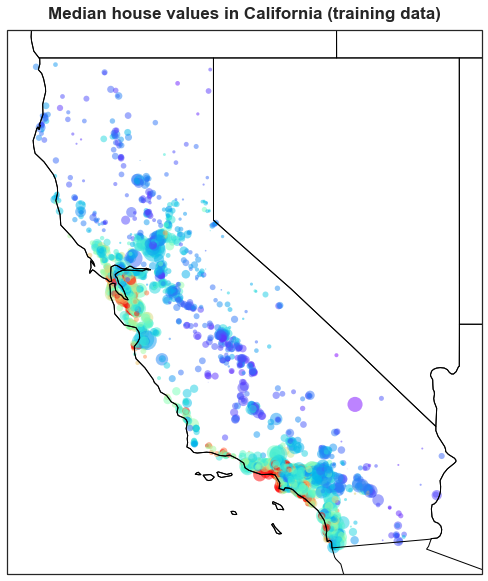

In [7]:
# Understanding this code is not essential for the tutorial 

import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Latitude and longitude for the edges of the map
lat1, lat2, lon1, lon2= 32, 42.5, -125, -114

# Create figures
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.Mercator())

# Get latitude and longitude for each data point
x, y = (train['Longitude'].to_numpy(), train['Latitude'].to_numpy())

# Scatter plot as heat map
ax.scatter(x,y,s=(train['Population'].to_numpy()/30.0), c=train['MedianHouseValue'].to_numpy(), 
           edgecolors='none', cmap=plt.get_cmap('rainbow'), alpha=0.5, transform=ccrs.PlateCarree())

# Add state borders and coast line
ax.add_feature(cfeature.STATES.with_scale('50m'))
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.set_extent([-125, -113.5, 32, 42.5], crs=ccrs.PlateCarree())

ax.set_title('Median house values in California (training data)', fontsize=17, y=1.01, fontweight='bold')

plt.show()

The two variables with strongest linear relationship with house values are the median income and the average occupancy. Further exploration through the scatter plots below reveal nonlinear patterns for the median income, average rooms, and average occupancy. Population, housing average age, and average bedrooms seem to have only weak relationships with house values. 

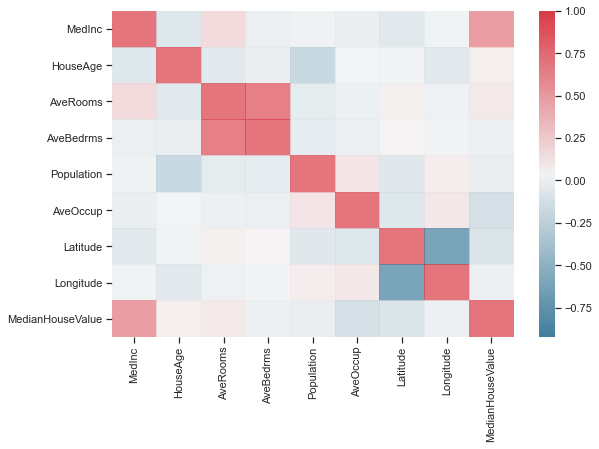

In [17]:
sns.heatmap(train.corr(), cmap=sns.diverging_palette(230, 10, n=1001), alpha=0.7)
plt.show()

The next cell shows the scatter plots for the predictors other than the latitude and longitude. We observe severe outliers in some of them, which as we will see below causes serious problems for the linear regression model. In contrast, tree-based methods are outliers in the predictor space.  We can also that the values of the `MedInc` response variable and `HouseAge` are truncated.

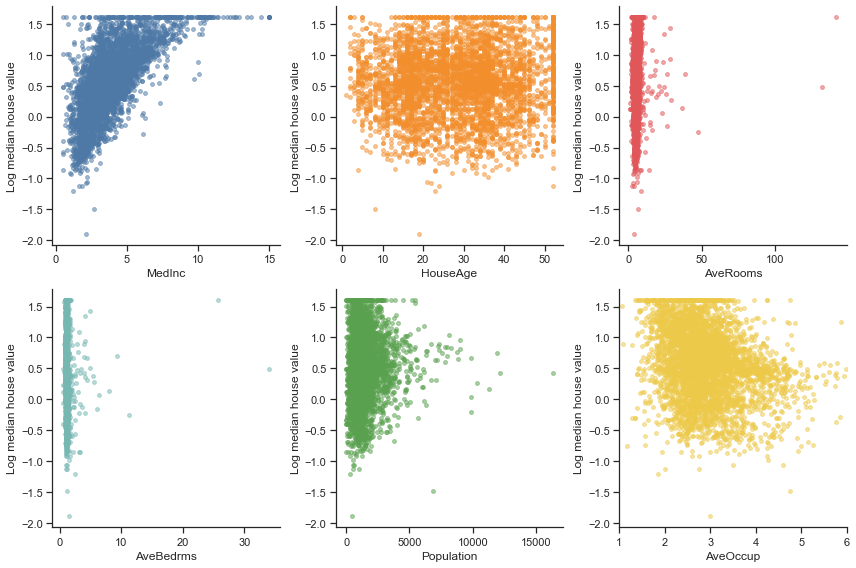

In [18]:
fig, axes = plt.subplots(2,3, figsize=(12,8))

for i, ax in enumerate(fig.axes):
    sns.regplot(train.iloc[:,i], y_train, color=colours[i], scatter_kws = {'s': 15, 'alpha': 0.5}, ax=ax, fit_reg=False)
    ax.set_ylabel('Log median house value')

ax.set_xlim(1, 6) # fixes a bug in the last plot

sns.despine()
plt.tight_layout()
plt.show()

## 2. Random forests

### 2.1 Fitting a random forest

We fit a random forest as follows. Remember that the key hyperparameters for a random forest regression are the number randomly selected candidate variables for each split (`max_features`) and the minimum leaf size (`min_samples_leaf`).  The number of trees should be as high as possible, but increasing the number of trees also increases the computational cost. 

In [10]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=2000, max_features = 3, min_samples_leaf= 1)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=2000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

### 2.2 Hyperparameter optimisation

We use a grid search together with cross-validation find the best values for the hyperparameters.

In [75]:
%%time

model = RandomForestRegressor(n_estimators = 1000)

search_space = {
    'min_samples_leaf': [1, 5, 10],
    'max_features': np.arange(1, X_train.shape[1]),
}

if use_pretrained:
    best_params = {'max_features': 3, 'min_samples_leaf': 1} 
    rf_search = RandomForestRegressor(n_estimators = 1000, **best_params)
    
    rf_search.fit(X_train, y_train)
    print('Best parameters found by randomised search:', best_params, '\n')
else:
    rf_search = GridSearchCV(model, search_space, cv = 5, n_jobs = 4)
    rf_search.fit(X_train, y_train)

    print('Best parameters found by randomised search:', rf_search.best_params_, '\n')

Best parameters found by randomised search: {'max_features': 3, 'min_samples_leaf': 1} 

Wall time: 9.08 s


In practice, it's better to refit the selected model with a larger number of trees. We skip this step to reduce the computational burden. 

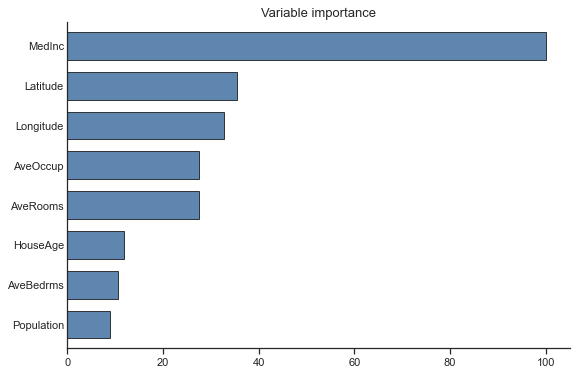

In [76]:
from statlearning import plot_feature_importance
plot_feature_importance(rf, predictors)
plt.show()

## 3. Least squares boosting


### 3.1 Fitting boosted regression trees

We start with the Scikit-Learn implementation of boosting available in the [<TT>GradientBoostingRegressor</TT>](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) class. Recall that boosting has three crucial hyperparameters:

<ol>
<li style="margin-top:15px; margin-bottom: 10px"> The learning rate.</li> 

<li style="margin-top:10px; margin-bottom: 10px"> The number of boosting iterations (the number trees).</li> 

<li style="margin-top:10px; margin-bottom: 10px"> The size of each tree.</li> 
</ol>

In addition, we may want to use stochastic gradient boosting by fitting each tree based on a subsample of the training data. 
The basic syntax for fitting a gradient boosting regressor with Scikit-Learn is as follows. 

In [22]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(learning_rate= 0.05, max_depth = 4, n_estimators= 750, subsample = 1.0)
gb.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=750,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

### 3.2 Hyperparameter optimisation with a randomised search

Careful hyperparameter optimisation is very important for gradient boosting.  Below, we configure a brief random search for illutrative purpose. It is useful to keep track of the running time, as this process can be very slow.  Usually, we would try more hyperparameter combinations to increase the chances that we find a configuration that optimises predictive performance.  

In [77]:
%%time

from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import uniform as unif
from scipy.stats import randint

model = GradientBoostingRegressor()

search_space = {
    'learning_rate': unif(0.005,0.1), # uniform distribution between 0.005 and 0.1
    'n_estimators' : randint(100, 2501), # discrete uniform distribution between 100 and 2500
    'max_depth' : [2 ,3, 4, 5, 6, 7, 8], # discrete uniform distribution between 2 and 4
    'subsample' : unif(0.5, 1), # uniform distribution between 0.5 and 1
}

if use_pretrained:
    best_params = {'learning_rate': 0.03513604954098934, 'max_depth': 7, 
                                   'n_estimators': 1525, 'subsample': 0.6529298225540288}
    gb = GradientBoostingRegressor(**best_params)
    
    gb.fit(X_train, y_train)
    print('Best parameters found by randomised search:', best_params, '\n')
else:
    # Increase the number of iterations if you want explore more hyperparameter configurations.
    gb = RandomizedSearchCV(model, search_space, n_iter = 32, cv = 5, n_jobs=4, random_state=1)
    gb.fit(X_train, y_train)
    gb = gb.best_estimator_
    print('Best parameters found by randomised search:', gb.best_params_, '\n')

Best parameters found by randomised search: {'learning_rate': 0.03513604954098934, 'max_depth': 7, 'n_estimators': 1525, 'subsample': 0.6529298225540288} 

Wall time: 14.8 s


We can make a variable importance plot to help with interpretation.

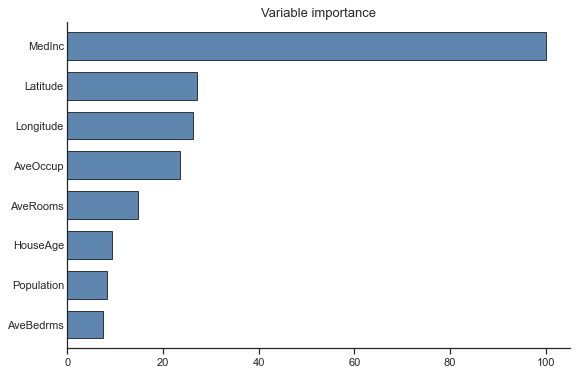

In [78]:
from statlearning import plot_feature_importance
plot_feature_importance(gb, predictors)
plt.show()

### 3.3 Hyperparameter optimisation with Bayesian optimisation

Bayesian hyperparameter optimisation can be useful for gradient boosting. We use the [scikit-optimize](https://scikit-optimize.github.io/stable/) package to do this. The code takes a long time to run, so we set a low number of iterations just to illustrate the method.

In [27]:
from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV

In [79]:
%%time
model = GradientBoostingRegressor()

search_space = {
    'learning_rate': Real(0.005, 0.1),
    'n_estimators' : Integer(100, 2500),
    'max_depth' : Integer(2, 8),
    'subsample' : Real(0.5, 1.0),
}

np.random.seed(42)
if use_pretrained:
    best_params = {'learning_rate': 0.04395987609106482, 'max_depth': 6, 
                   'n_estimators': 2339, 'subsample': 0.6578997967435244}
    gb_opt = GradientBoostingRegressor(**best_params)
    gb_opt.fit(X_train, y_train)
    print(best_params)
    
else:
    gb_opt =  BayesSearchCV(model, search_space, cv = 5,  n_iter= 16, scoring = 'neg_mean_squared_error', n_jobs=-1)
    gb_opt.fit(X_train, y_train)
    gb_opt.best_params_

{'learning_rate': 0.04395987609106482, 'max_depth': 6, 'n_estimators': 2339, 'subsample': 0.6578997967435244}
Wall time: 19.9 s


## 4. XGBoost

### 4.1 Fitting boosted trees with XGBoost

[XGBoost](https://xgboost.readthedocs.io/en/latest/) is a state-of-art gradient boosting library that is very popular among data scientist and [Kaggle](https://www.kaggle.com/) users. The easiest way to get started with XGBoost is to use the [Scikit-Learn API](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn) provided by the package. That makes the syntax similar to what we did above, except that we call the [XGBRegressor](http://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor) class from the XGBoost package. 

The basic syntax from is:

In [29]:
import xgboost as xgb

xbst = xgb.XGBRegressor(learning_rate= 0.05, max_depth = 4, n_estimators= 750, subsample = 1.0,  reg_lambda=0,
                       objective='reg:squarederror')
xbst.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=750, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=0, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)

As explained in the lecture notes, XGBoost implements a different version of gradient boosting that incorporates regularisation. Above, I set `reg_lambda=0` to fit a standard gradient boosting model without regularisation.

More generally, it's useful to pay attention to the following additional hyperparameters for XGBoost:

* `reg_lambda`: penalty for $\ell_2$ regularisation.

* `reg_alpha`: penalty for $\ell_1$ regularisation.

* `gamma`: penalty for the number of leaves.

*  `colsample_bytree`: fraction of predictors to be randomly sampled to construct each tree (see also `colsample_bylevel` and `colsample_bynode`).

See the [documentation](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn) for additional hyperparameters that may be useful to tune.

### 4.2 Hyperparameter optimisation with a randomised search

Note how XGBoost is much faster than the scikit-learn implementation. 

In [56]:
%%time

model = xgb.XGBRegressor(objective='reg:squarederror', reg_lambda=0)

search_space = {
    'learning_rate': unif(0.005,0.1), # uniform distribution between 0.005 and 0.1
    'n_estimators' : randint(100, 2501), # discrete uniform distribution between 100 and 2500
    'max_depth' : randint(1, 9), # discrete uniform distribution between 2 and 8
    'subsample' : unif(0.5, 1), # uniform distribution between 0.5 and 1
}

if use_pretrained:
    best_params = {'learning_rate': 0.0227341836730216, 'max_depth': 6, 'n_estimators': 1822, 'subsample': 0.5992601526671212}
    xbst_temp = xgb.XGBRegressor(objective='reg:squarederror', reg_lambda=0, **best_params)
    xbst_temp.fit(X_train, y_train)
    print('Best parameters found by randomised search:', best_params, '\n')
else:
    xbst = RandomizedSearchCV(model, search_space, n_iter = 32, cv = 5, random_state=87, n_jobs=4)
    xbst.fit(X_train, y_train)

    print('Best parameters found by randomised search:', xbst.best_params_, '\n')

    xbst = xbst.best_estimator_

Best parameters found by randomised search: {'learning_rate': 0.0227341836730216, 'max_depth': 6, 'n_estimators': 1822, 'subsample': 0.5992601526671212} 

Wall time: 3 s


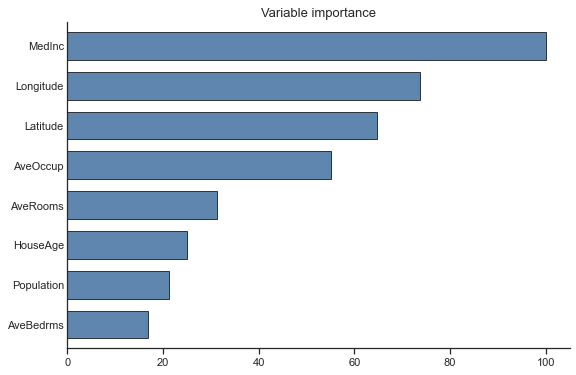

In [57]:
plot_feature_importance(xbst, labels=predictors)
plt.show()

### 4.3 Bayesian optimisation


More complex tuning requires expertise and patience. Here's an example of how we could use Bayesian hyperparameter optimisation.

In [61]:
%%time

model = xgb.XGBRegressor(objective='reg:squarederror')

search_space = {
    'reg_lambda':  (1e-10, 1e12, 'log-uniform'),
    'learning_rate': Real(0.005, 0.1),
    'n_estimators' : Integer(100, 5000),
    'max_depth' : Integer(2, 8),
    'subsample' : Real(0.5, 1.0),
    'colsample_bytree' : Real(0.25, 1.0),
}

np.random.seed(42)
if use_pretrained:
    best_params = {'colsample_bytree': 0.8592969912680225, 'learning_rate': 0.02132779833267327,
             'max_depth': 6, 'n_estimators': 4034, 'reg_lambda': 32.147796994182684, 'subsample': 0.5477275196074968}
    xbst_opt = xgb.XGBRegressor(objective='reg:squarederror', **best_params)
    xbst_opt.fit(X_train, y_train)
    print('Best parameters:', best_params, '\n')
else:
    xbst_opt =  BayesSearchCV(model, search_space, cv = 5,  n_iter=32, scoring = 'neg_mean_squared_error', n_jobs=4)
    xbst_opt.fit(X_train, y_train)
    print(xbst_opt.best_params_)

Best parameters found by randomised search: {'colsample_bytree': 0.8592969912680225, 'learning_rate': 0.02132779833267327, 'max_depth': 6, 'n_estimators': 4034, 'reg_lambda': 32.147796994182684, 'subsample': 0.5477275196074968} 

Wall time: 5.39 s


### 4.4 Early Stopping

The XGBoost functionality extends well beyond the scikit-learn API. Below, we construct a pure XGBoost implementation to select the number of boosting iterations by cross-validation and early stopping. 

In [62]:
%%time

dtrain = xgb.DMatrix(X_train, y_train) # we need to convert the data to the format required by xgboost
dtest  = xgb.DMatrix(X_test)

param = {
    'max_depth': 4, 
    'learning_rate': 0.05, 
    'subsample': 0.8,
    'silent' : 0, 
    'objective':'reg:squarederror',  
     }

cv = xgb.cv(param, dtrain, num_boost_round = 2000, nfold=5, early_stopping_rounds=50)

print(f'Selected number of boosting iterations: {cv.shape[0]}')
print(f'RMSE (CV): {cv.iloc[-1,2]:.4f}')

[23:50:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:50:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:50:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

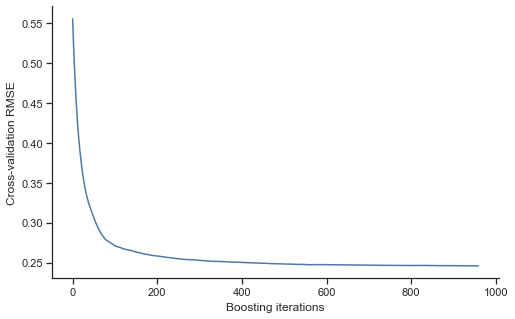

In [63]:
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(cv.iloc[:,2])
ax.set_ylabel('Cross-validation RMSE')
ax.set_xlabel('Boosting iterations')
sns.despine()
plt.show()

Fitting a XGBoost model with early stopping is also possible with the Scikit-learn API, if we work with a validation set. This is the ideal approach since we then avoid having to tune the number of boosting iterations with no additional computational cost.  

## 5. LightGBM

[LightGBM](http://lightgbm.readthedocs.io/en/latest/index.html) is a gradient boosting library developed by Microsoft. Similarly to XGBoost, it has a [Scikit-learn API](http://lightgbm.readthedocs.io/en/latest/Python-API.html#scikit-learn-api) that makes it simple to use. Conveniently, the implementation is very computationally efficient. 

LightGBM can involve many additional details like XGBosost, so we keep things simple in this section. Because of the way LightGBM [works](https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc), we should tune the number of leaves rather than the depth of the trees. 

In [65]:
import lightgbm as lgb

In [66]:
%%time

model = lgb.LGBMRegressor(objective='regression')

search_space = {
    'learning_rate': unif(0.005,0.1), # uniform distribution between 0.005 and 0.1
    'n_estimators' : randint(100, 2501), # discrete uniform distribution between 100 and 2500
    'num_leaves' : randint(2, 65), # discrete uniform distribution between 2 and 4
    'subsample' : unif(0.5, 1), # uniform distribution between 0.5 and 1
}

if use_pretrained:
    best_params = {'learning_rate': 0.06013249411979529, 'n_estimators': 605, 'num_leaves': 21, 'subsample': 0.6371357496288778}
    print('Best parameters found by randomised search:', best_params, '\n')
    
    lbst = lgb.LGBMRegressor(objective='regression', **best_params)
    lbst.fit(X_train, y_train)
else:
    lbst = RandomizedSearchCV(model, search_space, n_iter = 64, cv = 5, n_jobs=4, random_state=1)
    lbst.fit(X_train, y_train)
    lbst= lbst.best_estimator_
    print('Best parameters found by randomised search:', lbst.best_params_, '\n')

Best parameters found by randomised search: {'learning_rate': 0.06013249411979529, 'n_estimators': 605, 'num_leaves': 21, 'subsample': 0.6371357496288778} 

Wall time: 243 ms


## 6. Benchmark Models

### 6.1 Linear Regression

In [67]:
ols = LinearRegression()
ols.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### 6.2 Regression Tree

The basic syntax for fitting a regression tree by recursive binary splitting is the following, where we allow the tree to have a maximum depth of two for visualisation.  I also specify the minimum number of samples in the terminal nodes to highlight the importance explictly controlling this tuning parameter.

In [80]:
%%time

from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(min_samples_leaf=5)
path = model.cost_complexity_pruning_path(X_train, y_train)
alphas = path.ccp_alphas

search_space = {
    'ccp_alpha': alphas,
}

if use_pretrained:
    best_params = {'ccp_alpha': 0.00015225731722282206} 
    tree_search = DecisionTreeRegressor(min_samples_leaf=5, **best_params)
    
    tree_search.fit(X_train, y_train)
else:
    tree_search = GridSearchCV(model, search_space, cv = 5)
    tree_search.fit(X_train, y_train)

    tree = tree_search.best_estimator_

    print('Best parameters found by grid search:', tree_search.best_params_, '\n')

Wall time: 45.9 ms


## 7. Model selection

We start by fitting a model stack that includes all models. 

In [70]:
%%time 

from mlxtend.regressor import StackingCVRegressor
 
stack = StackingCVRegressor(regressors=[ols, tree, rf, gb, xbst_opt, lbst], meta_regressor=LinearRegression(), n_jobs=-1,
                           cv=5, random_state=10)
stack.fit(X_train, y_train)

Wall time: 1min 24s


StackingCVRegressor(cv=5,
                    meta_regressor=LinearRegression(copy_X=True,
                                                    fit_intercept=True,
                                                    n_jobs=None,
                                                    normalize=False),
                    n_jobs=-1, pre_dispatch='2*n_jobs', random_state=10,
                    refit=True,
                    regressors=[LinearRegression(copy_X=True,
                                                 fit_intercept=True,
                                                 n_jobs=None, normalize=False),
                                DecisionTreeRegressor(ccp_alpha=0.00015225731722282206,
                                                      criterion='mse',
                                                      max_depth=No...
                                              max_depth=-1,
                                              min_child_samples=20,
                             

Looking at the coefficients, we find that the stack essentially puts all the weight on the different implementations of boosting, with XGBoost getting the largest weight. The negative weights for the decision tree and the random forest are an indication of overfitting. 

In [71]:
stack.meta_regr_.coef_

array([ 0.04396295, -0.04500994,  0.03393064,  0.35965249,  0.30192476,
        0.31778723])

Our final model is a stack that keeps only the different versions of boosting. 

In [72]:
%%time 

stack = StackingCVRegressor(regressors=[gb, xbst_opt, lbst], meta_regressor=LinearRegression(), n_jobs=-1,
                           cv=5, random_state=10)
stack.fit(X_train, y_train)

Wall time: 49.3 s


StackingCVRegressor(cv=5,
                    meta_regressor=LinearRegression(copy_X=True,
                                                    fit_intercept=True,
                                                    n_jobs=None,
                                                    normalize=False),
                    n_jobs=-1, pre_dispatch='2*n_jobs', random_state=10,
                    refit=True,
                    regressors=[GradientBoostingRegressor(alpha=0.9,
                                                          ccp_alpha=0.0,
                                                          criterion='friedman_mse',
                                                          init=None,
                                                          learning_rate=0.03513604954098934,
                                                          loss='ls',
                                                          max_depth=7,
                                                          max_feature

In [73]:
stack.meta_regr_.coef_

array([0.35418374, 0.32344373, 0.32491332])

### 8. Evaluation

In [74]:
columns=['Test RMSE', 'Test R2', 'Test MAE']
rows=['Linear regression', 'Regression tree', 'Random forest', 'GBM', 'XGBoost', 'LightGBM', 'Stack']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[ols, tree, rf, gb, xbst_opt, lbst, stack]

for i, method in enumerate(methods):

    y_pred=method.predict(X_test)
    
    # The linear regression model is severely affected by outliers
    if method == ols:
        y_pred[y_pred>y_train.max()] = y_train.max()
        y_pred[y_pred<y_train.min()] = y_train.min()
    
    results.iloc[i,0] = np.sqrt(mean_squared_error(y_test, y_pred))
    results.iloc[i,1] = r2_score(y_test, y_pred)
    results.iloc[i,2] = mean_absolute_error(y_test, y_pred)

results.round(3)

,Test RMSE,Test R2,Test MAE
Linear regression,0.335,0.655,0.248
Regression tree,0.306,0.711,0.222
Random forest,0.253,0.802,0.183
GBM,0.232,0.834,0.163
XGBoost,0.230,0.837,0.163
LightGBM,0.231,0.835,0.164
Stack,0.226,0.842,0.159


### Formatting

These two cells below format the notebook for display online. Please omit them from your work.

In [ ]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Source+Sans+Pro|Open+Sans:800&display=swap');
</style>

In [ ]:
from IPython.core.display import HTML
style = open('css\jupyter.css', "r").read()
HTML('<style>'+ style +'</style>')